# Introduction to `Scikit-learn`

The `scikit-learn` package is an open-source library that provides a robust set of machine learning algorithms for Python. It is built upon the core Python scientific stack (*i.e.* NumPy, SciPy, Cython), and has a simple, consistent API, making it useful for a wide range of statistical learning applications.

<img src="http://1.bp.blogspot.com/-ME24ePzpzIM/UQLWTwurfXI/AAAAAAAAANw/W3EETIroA80/s1600/drop_shadows_background.png" width="800px"/>

## What is Machine Learning?

Machine Learning (ML) is about coding programs that automatically adjust their performance from exposure to information encoded in data. This learning is achieved via **tunable parameters** that are automatically adjusted according to performance criteria.

Machine Learning can be considered a subfield of Artificial Intelligence (AI).

There are three major classes of ML:

**Supervised learning**
: Algorithms which learn from a training set of *labeled* examples (exemplars) to generalize to the set of all possible inputs. Examples of supervised learning include regression and support vector machines.

**Unsupervised learning**
: Algorithms which learn from a training set of *unlableled* examples, using the features of the inputs to categorize inputs together according to some statistical criteria. Examples of unsupervised learning include k-means clustering and kernel density estimation.

**Reinforcement learning**
: Algorithms that learn via reinforcement from a *critic* that provides information on the quality of a solution, but not on how to improve it. Improved solutions are achieved by iteratively exploring the solution space. We will not cover RL in this course.

## Representing Data in `scikit-learn`

Most machine learning algorithms implemented in scikit-learn expect data to be stored in a
**two-dimensional array or matrix**.  The arrays can be
either ``numpy`` arrays, or in some cases ``scipy.sparse`` matrices.
The size of the array is expected to be `[n_samples, n_features]`

- **n_samples:**   The number of samples: each sample is an item to process (e.g. classify).
  A sample can be a document, a picture, a sound, a video, an astronomical object,
  a row in database or CSV file,
  or whatever you can describe with a fixed set of quantitative traits.
- **n_features:**  The number of features or distinct traits that can be used to describe each
  item in a quantitative manner.  Features are generally real-valued, but may be boolean or
  discrete-valued in some cases.

The number of features must be fixed in advance. However it can be very high dimensional
(e.g. millions of features) with most of them being zeros for a given sample. This is a case
where `scipy.sparse` matrices can be useful, in that they are
much more memory-efficient than numpy arrays.

# Example: Iris morphometrics

One of the datasets included with `scikit-learn` is a set of measurements for flowers, each being a member of one of three species: *Iris Setosa*, *Iris Versicolor* or *Iris Virginica*. 

<img src="http://d.pr/i/1dfvU+" width="400px"/>

In [30]:
from sklearn.datasets import load_iris
iris = load_iris()

In [31]:
iris.keys()

['target_names', 'data', 'target', 'DESCR', 'feature_names']

In [32]:
n_samples, n_features = iris.data.shape
n_samples, n_features

(150, 4)

In [33]:
iris.data[0]

array([ 5.1,  3.5,  1.4,  0.2])

The information about the class of each sample is stored in the ``target`` attribute of the dataset:

In [34]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [35]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], 
      dtype='|S10')

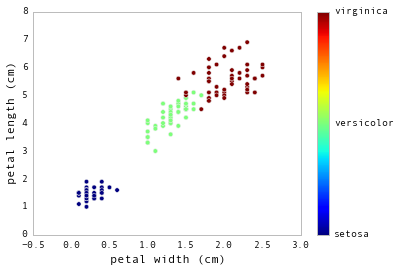

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

x_index = 3
y_index = 2

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])

plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True).fit(iris.data)
X_pca = pca.transform(iris.data)

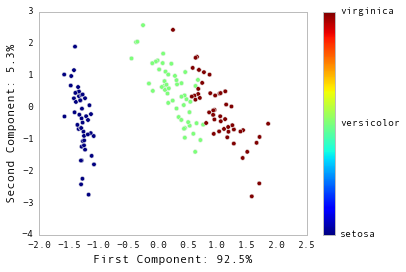

In [40]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
var_explained = pca.explained_variance_ratio_ * 100
plt.xlabel('First Component: {0:.1f}%'.format(var_explained[0]))
plt.ylabel('Second Component: {0:.1f}%'.format(var_explained[1]))

## `scikit-learn` interface

All objects within scikit-learn share a uniform common basic API consisting of three complementary interfaces: 

* **estimator** interface for building and ﬁtting models
* **predictor** interface for making predictions
* **transformer** interface for converting data.

The estimator interface is at the core of the library. It deﬁnes instantiation mechanisms of objects and exposes a fit method for learning a model from training data. All supervised and unsupervised learning algorithms (*e.g.*, for classiﬁcation, regression or clustering) are oﬀered as objects implementing this interface. Machine learning tasks like feature extraction, feature selection or dimensionality reduction are also provided as estimators.

Scikit-learn strives to have a uniform interface across all methods. For example, a typical **estimator** follows this template:

In [ ]:
class Estimator(object):
  
    def fit(self, X, y=None):
        """Fit model to data X (and y)"""
        self.some_attribute = self.some_fitting_method(X, y)
        return self
            
    def predict(self, X_test):
        """Make prediction based on passed features"""
        pred = self.make_prediction(X_test)
        return pred

For a given scikit-learn **estimator** object named `model`, several methods are available. Irrespective of the type of **estimator**, there will be a `fit` method:

- `model.fit` : fit training data. For supervised learning applications, this accepts two arguments: the data `X` and the labels `y` (e.g. `model.fit(X, y)`). For unsupervised learning applications, this accepts only a single argument, the data `X` (e.g. `model.fit(X)`).

> During the fitting process, the state of the **estimator** is stored in attributes of the estimator instance named with a trailing underscore character (\_). For example, the sequence of regression trees `sklearn.tree.DecisionTreeRegressor` is stored in `estimators_` attribute.

The **predictor** interface extends the notion of an estimator by adding a `predict` method that takes an array `X_test` and produces predictions based on the learned parameters of the estimator. In the case of supervised learning estimators, this method typically returns the predicted labels or values computed by the model. Some unsupervised learning estimators may also implement the predict interface, such as k-means, where the predicted values are the cluster labels.

**supervised estimators** are expected to have the following methods:

- `model.predict` : given a trained model, predict the label of a new set of data. This method accepts one argument, the new data `X_new` (e.g. `model.predict(X_new)`), and returns the learned label for each object in the array.
- `model.predict_proba` : For classification problems, some estimators also provide this method, which returns the probability that a new observation has each categorical label. In this case, the label with the highest probability is returned by `model.predict()`.
- `model.score` : for classification or regression problems, most (all?) estimators implement a score method.  Scores are between 0 and 1, with a larger score indicating a better fit.

Since it is common to modify or ﬁlter data before feeding it to a learning algorithm, some estimators in the library implement a **transformer** interface which deﬁnes a `transform` method. It takes as input some new data `X_test` and yields as output a transformed version. Preprocessing, feature selection, feature extraction and dimensionality reduction algorithms are all provided as transformers within the library.

**unsupervised estimators** will always have these methods:

- `model.transform` : given an unsupervised model, transform new data into the new basis. This also accepts one argument `X_new`, and returns the new representation of the data based on the unsupervised model.
- `model.fit_transform` : some estimators implement this method, which more efficiently performs a fit and a transform on the same input data.

## Regression Analysis

To demonstrate how `scikit-learn` is used, let's conduct a logistic regression analysis on a dataset for very low birth weight (VLBW) infants.

Data on 671 infants with very low (less than 1600 grams) birth weight from 1981-87 were collected at Duke University Medical Center by [OShea *et al.* (1992)](http://www.ncbi.nlm.nih.gov/pubmed/1635885). Of interest is the relationship between the outcome intra-ventricular hemorrhage and the predictors birth weight, gestational age, presence of pneumothorax, mode of delivery, single vs. multiple birth, and whether the birth occurred at Duke or at another hospital with later transfer to Duke. A secular trend in the outcome is also of interest.

The metadata for this dataset can be found [here](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/Cvlbw.html).

In [42]:
import pandas as pd

vlbw = pd.read_csv("../data/vlbw.csv", index_col=0)

subset = vlbw[['ivh', 'gest', 'bwt', 'delivery', 'inout', 
               'pltct', 'lowph', 'pneumo', 'twn', 'apg1']].dropna()

# Extract response variable
y = subset.ivh.replace({'absent':0, 'possible':1, 'definite':1})

# Standardize some variables
X = subset[['gest', 'bwt', 'pltct', 'lowph']]
X0 = (X - X.mean(axis=0)) / X.std(axis=0)

# Recode some variables
X0['csection'] = subset.delivery.replace({'vaginal':0, 'abdominal':1})
X0['transported'] = subset.inout.replace({'born at Duke':0, 'transported':1})
X0[['pneumo', 'twn', 'apg1']] = subset[['pneumo', 'twn','apg1']]
X0.head()

,gest,bwt,pltct,lowph,csection,transported,pneumo,twn,apg1
5,-0.381853,-0.640950,-1.756012,-1.669740,1,0,1,0,5
13,-0.381853,0.092756,-0.174208,-0.114754,0,0,1,0,6
14,-0.381853,0.370375,2.037845,1.662394,1,0,0,0,6
16,-1.236762,-1.255677,0.727914,0.329540,0,0,0,0,4
17,1.755419,1.599828,-0.124777,-0.484984,1,0,0,0,8


We split the data into a training set and a testing set. By default, 25% of the data is reserved for testing. This is the first of multiple ways that we will see to do this.

In [43]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X0, y)

The `LogisticRegression` model in scikit-learn employs a regularization coefficient `C`, which defaults to 1. The amount of regularization is lower with larger values of C.

Regularization penalizes the values of regression coefficients, while smaller ones let the coefficients range widely. Scikit-learn includes two penalties: a **l2** penalty which penalizes the sum of the squares of the coefficients (the default), and a **l1** penalty which penalizes the sum of the absolute values.

The reason for doing regularization is to let us to include more covariates than our data might otherwise allow. We only have a few coefficients, so we will set `C` to a large value.

In [45]:
from sklearn.linear_model import LogisticRegression

lrmod = LogisticRegression(C=1000)
lrmod.fit(X_train, y_train)

pred_train = lrmod.predict(X_train)
pred_test = lrmod.predict(X_test)

In [46]:
pd.crosstab(y_train, pred_train, 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,279,13
1,43,13


In [47]:
pd.crosstab(y_test, pred_test, 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,99,2
1,11,4


In [48]:
for name, value in zip(X0.columns, lrmod.coef_[0]):
    print('{0}:\t{1:.2f}'.format(name, value))

gest:	-0.68
bwt:	0.26
pltct:	-0.01
lowph:	-0.22
csection:	-1.04
transported:	0.93
pneumo:	1.24
twn:	-1.14
apg1:	-0.14


We can bootstrap some confidence intervals:

In [49]:
import numpy as np

n = 1000
boot_samples = np.empty((n, len(lrmod.coef_[0])))

for i in np.arange(n):
    boot_ind = np.random.randint(0, len(X0), len(X0))
    y_i, X_i = y.values[boot_ind], X0.values[boot_ind]
    
    lrmod_i = LogisticRegression(C=1000)
    lrmod_i.fit(X_i, y_i)

    boot_samples[i] = lrmod_i.coef_[0]

In [50]:
boot_samples.sort(axis=0)

In [51]:
boot_se = boot_samples[[25, 975], :].T

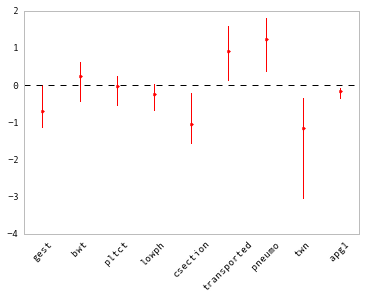

In [52]:
coefs = lrmod.coef_[0]
plt.plot(coefs, 'r.')
for i in range(len(coefs)):
    plt.errorbar(x=[i,i], y=boot_se[i], color='red')
plt.xlim(-0.5, 8.5)
plt.xticks(range(len(coefs)), X0.columns.values, rotation=45)
plt.axhline(0, color='k', linestyle='--')

## References

* [`scikit-learn` user's guide](http://scikit-learn.org/stable/user_guide.html)

---

In [29]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()